# Introduction to OCTA processing code

This document contains instructions for interactively running OCTA processing. It is meant to illustrate the architecture of the processing tool chain, the distinction between the OCT/OCTA libraries and processing scripts, and other important (and confusing) issues. In actuality, the OCTA data will be processed using Python scripts (i.e., batch processing), with no interaction with the user.

The first step in constructing a script is to import the tools you'll need. ```numpy``` and ```matplotlib``` are the standard numerical and plotting libraries in Python, and are always imported. The ```__future___``` and ```builtins``` imports implement some Python 3 functions, which will make porting this to Python 3 easier.

```octoblob``` is the unfortunate name I've chosen for the OCT/OCTA processing libraries. It is a descendent of the now obsolete ```octopod``` and ```cuttlefish``` libraries we've used in the past. We could have imported all the classes and functions from octoblob with ```from octoblob import *```, but it's better practice to keep the module name around, so that when module functions are called (e.g. ```bscan = blob.make_bscan(data)```), it's clear that the function is coming from the octoblob package, and clear where one needs to go to find the definition of the function. 

In [1]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
from builtins import *
import numpy as np
from matplotlib import pyplot as plt
import octoblob as blob

## Some architectural principles

1. One reasonable way to think about scientific software is to split it into two categories: **libraries** and **scripts**. Libraries are collections of functions (and *classes*--more on that later) where each function and class has a well-defined goal, and the implementations have been extensively tested or otherwise verified to be correct. We *really* don't want any errors in a library. Scripts are the day-to-day programs we run. Some are batch scripts that process lots of data autonomously, and others are exploratory, where we run them to see what the data looks like, often in order to help us design the next step in the processing pipeline. Sometimes a portion of a script becomes used so frequently that it makes sense to turn it into a library functions and thus simplify the script.

2. Specifically with regard to the OCT/OCTA processing pipeline, I believe the libraries should be split into two parts: 1) a library for reading raw data and getting it organized, and 2) a library for turning raw data into OCT/OCTA images. The first of these is handled by a *class*, and the second is handled by a set of *functions*.

3. **Classes**. If you're not familiar with object-oriented programming, all you need to know about a class is that it is a specification for an *object*, i.e. a list of functions and variables that are stored together and somehow insulated from the rest of the code. The raw OCT data is handled by a class, because it needs to keep track of lots of information about the data. We create an ```OCTRawData``` class, and it keeps track of how many bytes there are per pixel, how many pixels per spectrum, how many spectra per B-scan, etc. By implementing this with a class, we don't have to specify how to get the raw data every time we need a new frame. We just instantiate the object and then ask it for frames, which will be illustrated below.

## Parameters for the ```OCTRawData``` class

The ```OCTRawData``` class needs to know how to get a frame out of the file, and to do that it needs a bunch of parameters. Let's specify these first. They should be self-explanatory, but trailing comments may clarify in some cases.

In [2]:
# PARAMETERS FOR RAW DATA SOURCE
filename = './octa_test_set.unp' # name of the raw data file
n_vol = 1 # number of volumes
n_slow = 4 # number of B-scans in each volume
n_repeats = 5 # number of repeats for OCTA data
n_fast = 2500 # number of A-scans per B-scan x number of repeats
n_skip = 500 # number of A-scans to skip at the start
n_depth = 1536 # number of pixels per spectrum
bit_shift_right = 4 # ignore for now
dtype=np.uint16 # the data type of the raw data

fbg_position = 148 # if there is an FBG, approximately where is it located
spectrum_start = 159 # where does the spectral data start (i.e. after FBG)
spectrum_end = 1459 # where does the spectral data end (i.e., before any dead/dark time at the end)

Now we can instantiate the ```OCTRawData``` object, which will later be used to get frames.

In [3]:
src = blob.OCTRawData(filename,n_vol,n_slow,n_fast,n_depth,n_repeats,
                      fbg_position=fbg_position,
                      spectrum_start=spectrum_start,spectrum_end=spectrum_end,
                      bit_shift_right=bit_shift_right,
                      n_skip=n_skip,dtype=dtype)

File size incorrect.
30720000	expected
32256000	actual
n_vol		1
n_slow		4
n_repeats	5
n_fast		2500
n_depth		1536
bytes_per_pixel	2
total_expected_size	30720000


The "File size incorrect" warning is just telling us that there are more bytes in the file than we need. This is because using Yifan's software and the Axsun source, there's no synchronization between the slow scanner and the data acquisition, such that the first set of N repeats can begin on any of the first N frames.

## Parameters for OCT/OCTA processing

In addition to the raw data parameters, the code needs to know how to process the OCT data. These parameters are of greater interest to OCT scientists, and are subject to continual revision and refinement.

In [4]:
# PROCESSING PARAMETERS
mapping_coefficients = [12.5e-10,-12.5e-7,0.0,0.0]
dispersion_coefficients = [0.0,1.5e-6,0.0,0.0]

fft_oversampling_size = 4096

# Cropping parameters:
bscan_z1 = 3147
bscan_z2 = -40 # negative indices are relative to the end of the array
bscan_x1 = 0
bscan_x2 = -100 # negative indices are relative to the end of the array

## Pulling and processing an OCTA frame

Let's say we want to process one OCTA frame, using the OCTRawData object ```src``` defined above.

First, we need to get the raw spectra. Let's adopt the convention of calling these **frames**. A frame has dimensions ```n_k * n_x```, where ```n_k``` is the number of points in the k-dimension (the vertical/first dimension, by convention) and ```n_x``` is the number of points in the fast scan dimension, including repeats. Our B-scans are 500 pixels wide, and we have 5 repeats, so a single frame will contain 2500 A-scans. Remember that Python, like every sane programming language, begins indices with 0, not 1. We'll get the first frame and see what it looks like.

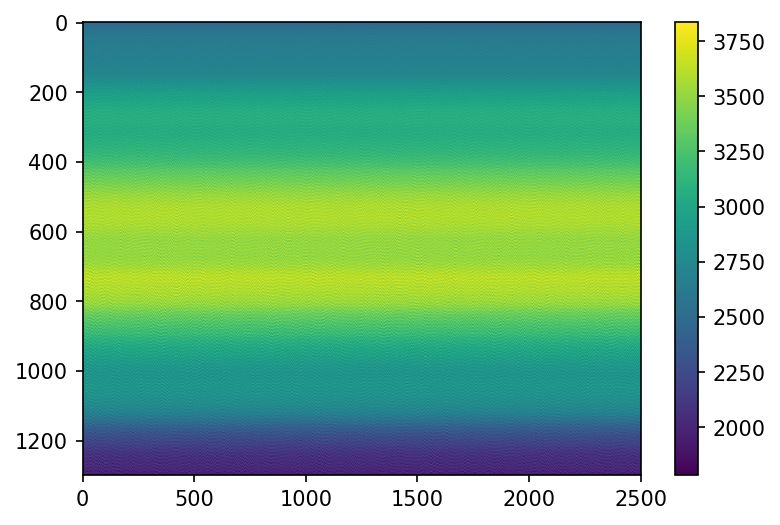

In [5]:
frame = src.get_frame(0)
plt.figure(dpi=150)
plt.imshow(frame,aspect='auto')
plt.colorbar()
plt.show()

## OCT processing pipeline

The next steps in the process are 1) DC-subtraction, 2) k-resampling, 3) dispersion compensation, 4) windowing, and 5) FFTing (and oversampling) the spectra into a B-scan. These are illustrated next.

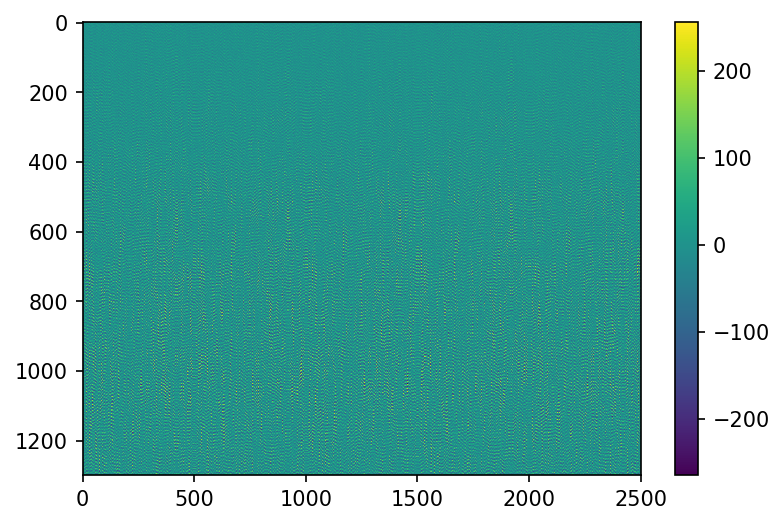

In [6]:
frame = blob.dc_subtract(frame)
plt.figure(dpi=150)
plt.imshow(frame,aspect='auto')
plt.colorbar()
plt.show()

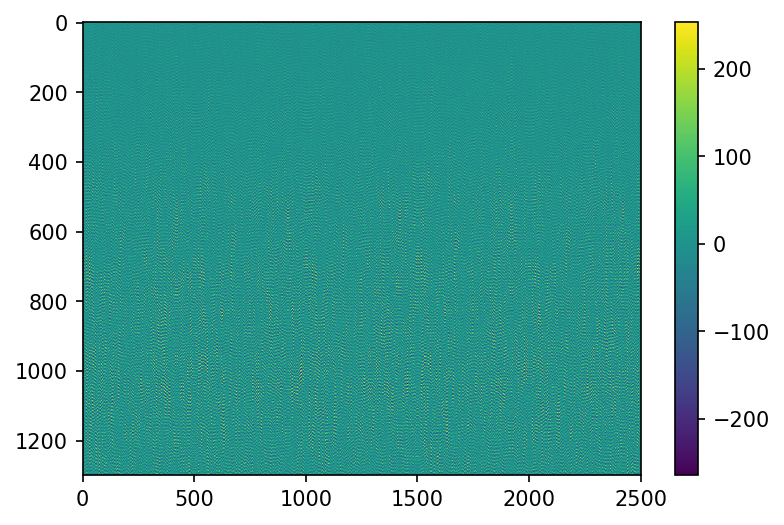

In [7]:
frame = blob.k_resample(frame,mapping_coefficients)
plt.figure(dpi=150)
plt.imshow(frame,aspect='auto')
plt.colorbar()
plt.show()

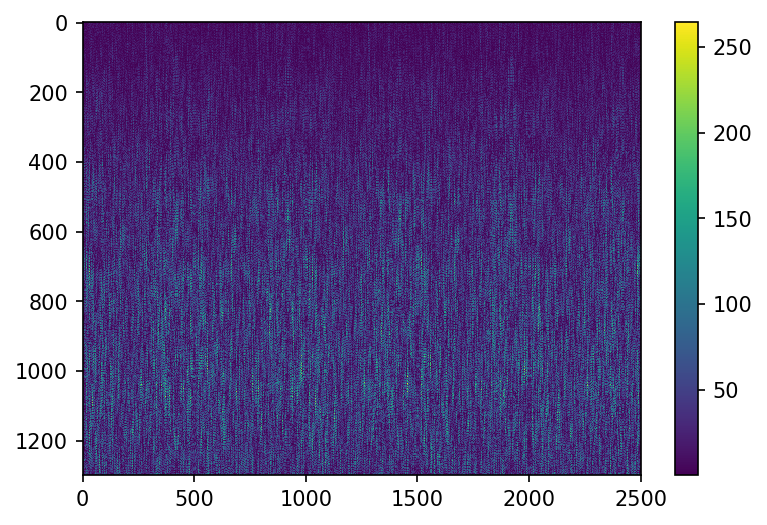

In [8]:
frame = blob.dispersion_compensate(frame,dispersion_coefficients)
plt.figure(dpi=150)
plt.imshow(np.abs(frame),aspect='auto') # need 'abs' because dispersion compensation introduces imaginary component
plt.colorbar()
plt.show()

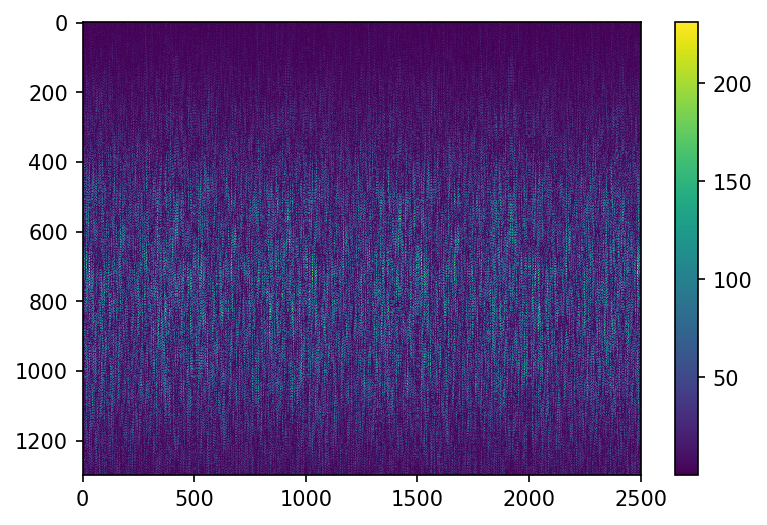

In [9]:
frame = blob.gaussian_window(frame,0.9)
plt.figure(dpi=150)
plt.imshow(np.abs(frame),aspect='auto') # need 'abs' because dispersion compensation introduces imaginary component
plt.colorbar()
plt.show()

### Let's have a look at the Gaussian window, just for fun, by running it on a vector of ones

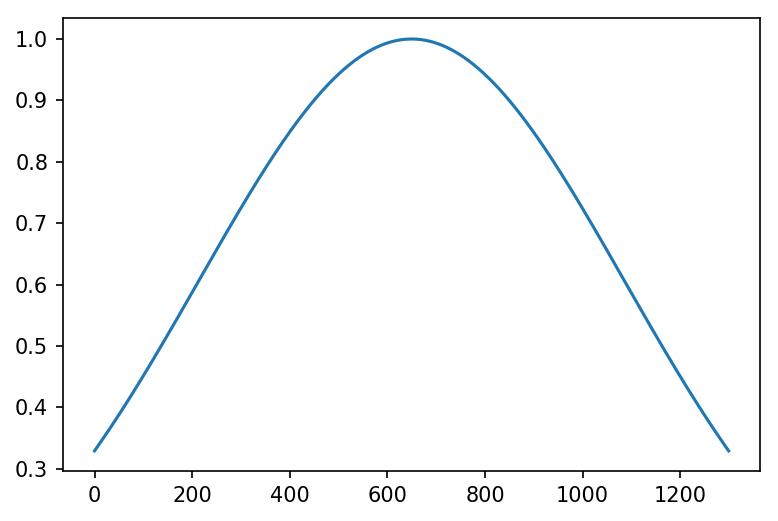

In [10]:
window_shape = blob.gaussian_window(np.ones(frame.shape[0]),0.9)
plt.figure(dpi=150)
plt.plot(window_shape)
plt.show()

### Now we generate a B-scan from the spectra

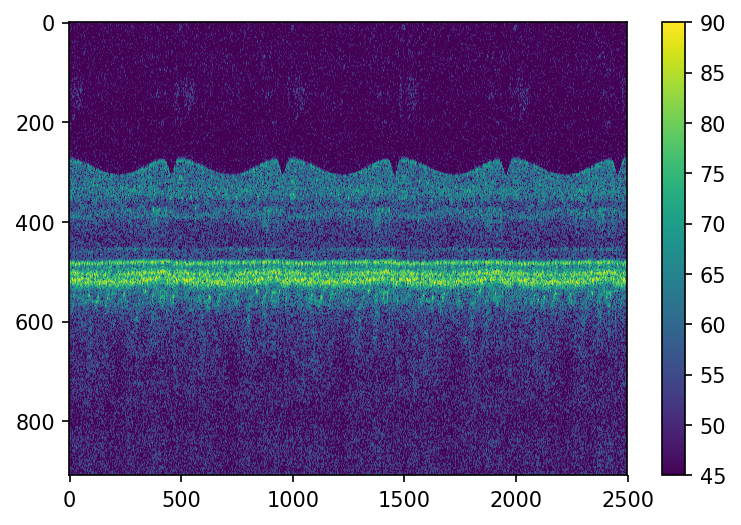

In [11]:
bscan = blob.spectra_to_bscan(frame,oversampled_size=fft_oversampling_size,z1=bscan_z1,z2=bscan_z2)
dB_bscan = 20*np.log10(np.abs(bscan))
# define rough contrast lims--if our sensitivity is 90 dB and our dynamic range is 45 dB, then (45,90) will work.
clim = (45,90)
plt.figure(dpi=150)
plt.imshow(dB_bscan,clim=(45,90),aspect='auto') # need 'abs' because dispersion compensation introduces imaginary component
plt.colorbar()
plt.show()

### Now we have to reshape the compound B-scan into a stack of 5 (n_repeats) individual B-scans

We'll check the shape of the stack (3D array), and then we'll visualize the first one in the stack, as sanity checks.

(909, 400, 5)


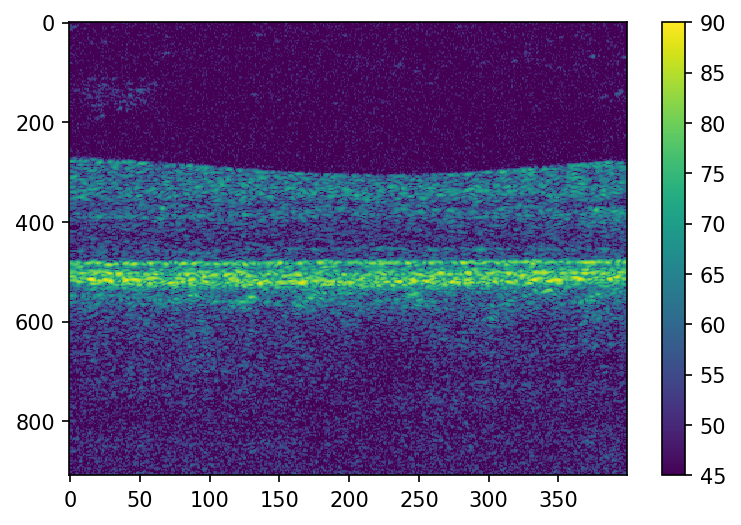

In [12]:
stack_complex = blob.reshape_repeats(bscan,n_repeats,x1=bscan_x1,x2=bscan_x2)
print(stack_complex.shape)
# remember that the original array bscan was complex; we used abs and log10 to visualize it before
dB_first_bscan = 20*np.log10(np.abs(stack_complex[:,:,0]))
# define rough contrast lims--if our sensitivity is 90 dB and our dynamic range is 45 dB, then (45,90) will work.
plt.figure(dpi=150)
plt.imshow(dB_first_bscan,clim=(45,90),aspect='auto') # need 'abs' because dispersion compensation introduces imaginary component
plt.colorbar()
plt.show()

### Lastly, we'll convert this stack of complex repeats into an angiogram

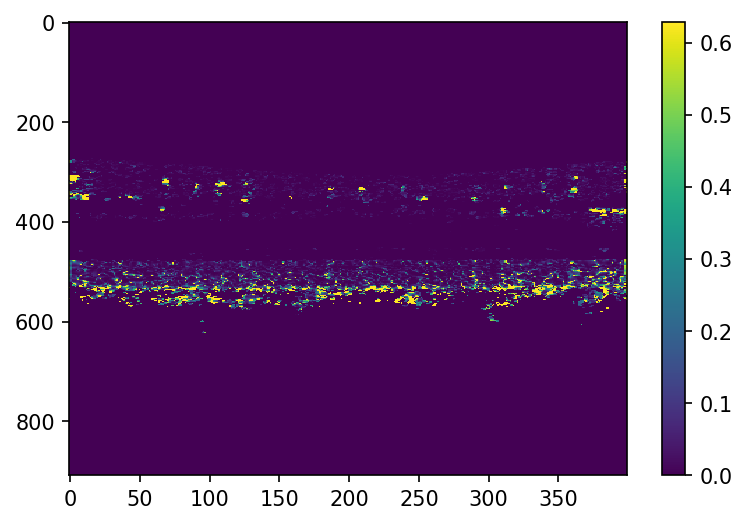

In [13]:
phase_variance = blob.make_angiogram(stack_complex)
plt.figure(dpi=150)
plt.imshow(phase_variance,clim=(0,0.2*np.pi),aspect='auto') # need 'abs' because dispersion compensation introduces imaginary component
plt.colorbar()
plt.show()

### The OCTA processing functions

Obviously a lot of the work is buried in the OCTA processing functions, and we'll eventually document all of those clearly as well. Here, for example, is the 